In [ ]:
pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 8.2 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3147269 sha256=0eaa7c403188bc761abf48b0e4497f6e5c3e7cb5791b7782cbf0eae6daa14f04
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import pandas as pd
import io
import os 
import fasttext
from pandas.errors import EmptyDataError
from google.colab import drive
from fasttext import load_model
drive.mount('/content/drive')
log_dir="/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/File log"
dns_dir="/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/File DNS/content/drive/MyDrive/Progetto Advanced Cybersecurity/File DNS"
gram_dir="/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Divisione DNS"

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Log_Files.zip" -d "/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/File log" #esegui solo una volta

In [ ]:
!unzip  "/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele.zip" -d "/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/" #esegui solo una volta

Archive:  /content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele.zip
a630830756ce82508700e2eba647ed7121104735
   creating: /content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/
 extracting: /content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/.gitignore  
   creating: /content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/Code/
  inflating: /content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/Code/DatasetBuilding.py  
   creating: /content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/Code/ELMo/
  inflating: /content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/Code/ELMo/saved_model.pb  
 extracting: /content/drive/MyDrive/Progetto_Advanced_Cybersecurity/d

# **Estrazione DNS dai file di log**

---



In [ ]:
def estrai_dns(dir_input, dir_output):
  dns_estratti= 0
  for filename in os.listdir(dir_input):
    file = open(dir_input+'/'+filename, "r")
    print("Estrazione DNS dal file di log:"+filename)
    lines= file.readlines()
    linee_ripulite = []
    for line in lines:
      elem= line.split(";")
      if(len(elem)<5):
        #print("riga sbagliata")
        continue
      dns = elem[5]
      #effettuo l'ETL dei log
      if ripulisci_log(dns):
        if (len(elem) == 10):
          linee_ripulite.append(line)
    try:
        df = pd.read_csv(io.StringIO('\n'.join(linee_ripulite)), sep=';', header=None, lineterminator='\n')
        #per ogni riga prendo solo i DNS e ne estraggo il 20%
        df = df.drop_duplicates(subset = [5])
        df = df.sample(frac=0.2)
        dns_estratti= dns_estratti+ len(df)
        #scrivo i DNS estratti in un file di output
        with open(dir_output + '/' + filename.split('.')[0] + ".log","w") as out:
          out.writelines('\n'.join(df.loc[:, 5].str[:-1].to_list()))
          out.close()
    except EmptyDataError:
        print('File di log vuoto: '+ filename)
    except Exception as e:
        print("linea errata")
  print("DNS estratti:"+ str(dns_estratti))


def ripulisci_log(dns):
  substring='arpa'
  campi= dns.split(".")
  #elimino tutti i DNS con numero di caratteri maggiore di 100 e quelli rappresentati da indirizzi IP
  if((campi[0].isdigit() and campi[1].isdigit() and campi[2].isdigit() and campi[3].isdigit()) or (campi[0]=='_' and campi[1].isdigit() and campi[2].isdigit()) or len(dns)>100 or substring in dns):
    return False
  else:
    return True


estrai_dns(log_dir,dns_dir)

Estrazione DNS dal file di log:pdns_2020_05_04_12.log
Estrazione DNS dal file di log:pdns_2020_05_09_00.log
Estrazione DNS dal file di log:pdns_2020_06_19_05.log
Estrazione DNS dal file di log:pdns_2020_04_30_01.log
Estrazione DNS dal file di log:pdns_2020_04_27_12.log
Estrazione DNS dal file di log:pdns_2020_06_17_17.log
Estrazione DNS dal file di log:pdns_2020_04_29_12.log
Estrazione DNS dal file di log:pdns_2020_05_22_06.log
Estrazione DNS dal file di log:pdns_2020_05_02_10.log
Estrazione DNS dal file di log:pdns_2020_06_14_00.log
Estrazione DNS dal file di log:pdns_2020_07_13_20.log
Estrazione DNS dal file di log:pdns_2020_07_17_18.log
Estrazione DNS dal file di log:pdns_2020_07_05_20.log
Estrazione DNS dal file di log:pdns_2021_03_26_15.log
Estrazione DNS dal file di log:pdns_2021_03_24_19.log
Estrazione DNS dal file di log:pdns_2021_03_17_02.log
Estrazione DNS dal file di log:pdns_2021_03_29_10.log
Estrazione DNS dal file di log:pdns_2021_04_17_15.log
Estrazione DNS dal file di l

# **Divisione DNS in unigrammi, bigrammi e trigrammi**

In [ ]:
#per ogni DNS trovato lo divido in unigrammi e lo salvo in un nuovo file
def dividi_dns_uni(input_dir, output_dir):
    unigrams=[]
    for filename in os.listdir(input_dir):
      file = open(input_dir+'/'+filename, "r")
      print("Divisione in unigram del file:"+filename)
      lines= file.readlines()
      for line in lines:
        elem=line.replace(".","")
        unigrams.append(list(elem))
    try:
      with open(output_dir + '/'  + "dns-unigram"+".log","w") as out:
        for elem in unigrams:
          out.writelines(' '.join(elem))
        out.close()
    except Exception as e:
      print("Errore"+e)

  
dividi_dns_uni(dns_dir,gram_dir)

Divisione in unigram del file:pdns_2020_05_04_12.log
Divisione in unigram del file:pdns_2020_06_19_05.log
Divisione in unigram del file:pdns_2020_04_30_01.log
Divisione in unigram del file:pdns_2020_05_09_00.log
Divisione in unigram del file:pdns_2020_06_17_17.log
Divisione in unigram del file:pdns_2020_04_27_12.log
Divisione in unigram del file:pdns_2020_05_22_06.log
Divisione in unigram del file:pdns_2020_05_02_10.log
Divisione in unigram del file:pdns_2020_04_29_12.log
Divisione in unigram del file:pdns_2020_06_14_00.log
Divisione in unigram del file:pdns_2020_07_13_20.log
Divisione in unigram del file:pdns_2020_07_17_18.log
Divisione in unigram del file:pdns_2020_07_05_20.log
Divisione in unigram del file:pdns_2021_03_26_15.log
Divisione in unigram del file:pdns_2021_03_24_19.log
Divisione in unigram del file:pdns_2021_03_17_02.log
Divisione in unigram del file:pdns_2021_04_17_15.log
Divisione in unigram del file:pdns_2021_03_29_10.log
Divisione in unigram del file:pdns_2021_04_18_

In [ ]:
def dividi_dns_di(input_dir, output_dir):
    digrams=[]
    for filename in os.listdir(input_dir):
      file = open(input_dir+'/'+filename, "r")
      print("Divisione in digram del file:"+filename)
      lines= file.readlines()
      for line in lines:
        elem=line.replace(".","")
        digrams.append(string_to_list_in_pairs(elem.replace("\n","")))
    try:
      with open(output_dir + '/' + "dns-digram"+".log","w") as out:
        for elem in digrams:
          out.writelines(' '.join(elem)+'\n')
        out.close()
    except Exception as e:
      print("Errore"+e)

def string_to_list_in_pairs (s):
    return [''.join(pair) for pair in zip(s[:-1], s[1:])]

  
dividi_dns_di(dns_dir,gram_dir)

Divisione in digram del file:pdns_2020_05_04_12.log
Divisione in digram del file:pdns_2020_06_19_05.log
Divisione in digram del file:pdns_2020_04_30_01.log
Divisione in digram del file:pdns_2020_05_09_00.log
Divisione in digram del file:pdns_2020_06_17_17.log
Divisione in digram del file:pdns_2020_04_27_12.log
Divisione in digram del file:pdns_2020_05_22_06.log
Divisione in digram del file:pdns_2020_05_02_10.log
Divisione in digram del file:pdns_2020_04_29_12.log
Divisione in digram del file:pdns_2020_06_14_00.log
Divisione in digram del file:pdns_2020_07_13_20.log
Divisione in digram del file:pdns_2020_07_17_18.log
Divisione in digram del file:pdns_2020_07_05_20.log
Divisione in digram del file:pdns_2021_03_26_15.log
Divisione in digram del file:pdns_2021_03_24_19.log
Divisione in digram del file:pdns_2021_03_17_02.log
Divisione in digram del file:pdns_2021_04_17_15.log
Divisione in digram del file:pdns_2021_03_29_10.log
Divisione in digram del file:pdns_2021_04_18_20.log
Divisione in

In [ ]:
def dividi_dns_tri(input_dir, output_dir):
    trigrams=[]
    for filename in os.listdir(input_dir):
      file = open(input_dir+'/'+filename, "r")
      print("Divisione in trigram del file:"+filename)
      lines= file.readlines()
      for line in lines:
        elem=line.replace(".","")
        trigrams.append(string_to_list_in_tris(elem.replace("\n","")))
    try:
      with open(output_dir + '/' + "dns-trigram"+".log","w") as out:
        for elem in trigrams:
          out.writelines(' '.join(elem)+'\n')
        out.close() 
    except Exception as e:
      print("Errore"+e)

def string_to_list_in_tris (s):
    return [''.join(pair) for pair in zip(s[:-1], s[1:], s[2:])]
  
dividi_dns_tri(dns_dir,gram_dir)

Divisione in n-gram del file:pdns_2020_05_04_12.log
Divisione in n-gram del file:pdns_2020_06_19_05.log
Divisione in n-gram del file:pdns_2020_04_30_01.log
Divisione in n-gram del file:pdns_2020_05_09_00.log
Divisione in n-gram del file:pdns_2020_06_17_17.log
Divisione in n-gram del file:pdns_2020_04_27_12.log
Divisione in n-gram del file:pdns_2020_05_22_06.log
Divisione in n-gram del file:pdns_2020_05_02_10.log
Divisione in n-gram del file:pdns_2020_04_29_12.log
Divisione in n-gram del file:pdns_2020_06_14_00.log
Divisione in n-gram del file:pdns_2020_07_13_20.log
Divisione in n-gram del file:pdns_2020_07_17_18.log
Divisione in n-gram del file:pdns_2020_07_05_20.log
Divisione in n-gram del file:pdns_2021_03_26_15.log
Divisione in n-gram del file:pdns_2021_03_24_19.log
Divisione in n-gram del file:pdns_2021_03_17_02.log
Divisione in n-gram del file:pdns_2021_04_17_15.log
Divisione in n-gram del file:pdns_2021_03_29_10.log
Divisione in n-gram del file:pdns_2021_04_18_20.log
Divisione in

# **Addestramento modelli FastText**

## Addestramento

In [ ]:
unigram="/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Divisione DNS/dns-unigram.log"
uni_model=fasttext.train_unsupervised(input=unigram, dim=128, model='skipgram')
uni_model.save_model("/content/drive/MyDrive/Progetto_Advanced Cybersecurity/unigram_model.bin")

In [ ]:
digram="/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Divisione DNS/dns-digram.log"
di_model=fasttext.train_unsupervised(input=digram, dim=128, model='skipgram')
di_model.save_model("/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/digram_model.bin")

In [ ]:
trigram="/content/drive/MyDrive/Progetto Advanced Cybersecurity/Divisione DNS/dns-trigram.log"
tri_model=fasttext.train_unsupervised(input=trigram, dim=128, model='skipgram')
tri_model.save_model("/content/drive/MyDrive/Progetto Advanced Cybersecurity/trigram_model.bin")

## Creazione file vec

In [ ]:
# original BIN model loading
f = fasttext.load_model("/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/unigram_model.bin")
lines=[]

# get all words from model
words = f.get_words()

with open("/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/Code/vec/char.vec",'w') as file_out:
    
    # the first line must contain number of total words and vector dimension
    file_out.write(str(len(words)) + " " + str(f.get_dimension()) + "\n")

    # line by line, you append vectors to VEC file
    for w in words:
        v = f.get_word_vector(w)
        vstr = ""
        for vi in v:
            vstr += " " + str(vi)
        try:
            file_out.write(w + vstr+'\n')
        except:
            pass


In [ ]:
f = fasttext.load_model("/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/digram_model.bin")
lines=[]

# get all words from model
words = f.get_words()

with open("/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/Code/vec/bigram.vec",'w') as file_out:
    
    # the first line must contain number of total words and vector dimension
    file_out.write(str(len(words)) + " " + str(f.get_dimension()) + "\n")

    # line by line, you append vectors to VEC file
    for w in words:
        v = f.get_word_vector(w)
        vstr = ""
        for vi in v:
            vstr += " " + str(vi)
        try:
            file_out.write(w + vstr+'\n')
        except:
            pass


In [ ]:
f = fasttext.load_model("/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/trigram_model.bin")
lines=[]

# get all words from model
words = f.get_words()

with open("/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/Code/vec/trigram.vec",'w') as file_out:
    
    # the first line must contain number of total words and vector dimension
    file_out.write(str(len(words)) + " " + str(f.get_dimension()) + "\n")

    # line by line, you append vectors to VEC file
    for w in words:
        v = f.get_word_vector(w)
        vstr = ""
        for vi in v:
            vstr += " " + str(vi)
        try:
            file_out.write(w + vstr+'\n')
        except:
            pass


# **Addestramento Stacked**

In [ ]:
path_architetture= '/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/dga-mixed-embeddings-ensemble-incicco_emanuele/Code'
os.chdir(path_architetture)

In [ ]:
!pip install keras==2.3.1 tensorflow-gpu==1.15.3 h5py==2.10.0 wandb -q 

     |████████████████████████████████| 377 kB 31.6 MB/s 
     |████████████████████████████████| 411.0 MB 37 kB/s 
     |████████████████████████████████| 2.9 MB 50.7 MB/s 
     |████████████████████████████████| 1.8 MB 55.9 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 3.8 MB 62.8 MB/s 
     |████████████████████████████████| 503 kB 65.4 MB/s 
     |████████████████████████████████| 181 kB 73.1 MB/s 
     |████████████████████████████████| 145 kB 69.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.3.1 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires tensorboard<2.9,>=2.8, but you have tensorboard 1.15.0 which is incompatible.
ten

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math 

def get_confusion_matrix (path=None): 
  df_label = pd.read_csv(path)
  #print('DF NO ETL SHAPE : {}'.format(df_label.shape))
  df_etl = pd.read_csv(path, header=0, usecols=[*range(1,52)]) 
  #print('DF ETL SHAPE : {}'.format(df_etl.shape))

  #normalizzazione
  scaler = MinMaxScaler()
  scaler.fit(df_etl)
  scaled = scaler.fit_transform(df_etl)
  scaled_df=pd.DataFrame(scaled,columns=df_etl.columns)
  trunc = lambda x: math.trunc(10 * x) / 10;
  scaled_df = scaled_df.applymap(trunc)

  #plot fig
  fig, figa = plt.subplots(figsize=(30, 30), dpi=180)
  ax = sns.heatmap(scaled_df, annot=True, cmap='Greens', fmt="g", ax=figa)

  ax.set_title('Confusion Matrix\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels 
  ax.xaxis.set_ticklabels(df_label.iloc[:,0], rotation = 45, ha="right")
  ax.yaxis.set_ticklabels(df_label.iloc[:,0], rotation = 45, ha="right")

  ## Display
  plt.show()
  #SAVE FIG 
  
  plt.savefig(dpi=180, figsize=(30, 30), transparent=False, fname='Confusion_matrix-FINAL.png')

## Addestramento con percentuale di train 0.017

In [ ]:
!python3 Main.py --dataset-path ../Dataset/umudga_1k.csv --output-path '/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Reports/Report/0.017' --model Stacking --epochs 20 --with-training --train-perc 0.017 --starting-ext-fold-nr 5 --starting-int-fold-nr 6

Using TensorFlow backend.

#############################
Pre-processing started.
#############################


#############################
2-gram pre-processing started.
Number of (different) 2-gram tokens: 1344
Max length of 2-gram tokens: 45
Found 4484 fastText pre-trained embedding vectors.

#############################
3-gram pre-processing started.
Number of (different) 3-gram tokens: 41647
Max length of 3-gram tokens: 44
Found 108494 fastText pre-trained embedding vectors.

#############################
1-gram pre-processing started.
Number of (different) 1-gram tokens: 37
Max length of 1-gram tokens: 46
Found 100 fastText pre-trained embedding vectors.

#############################
Pre-processing terminated.
#############################


#############################
Dictionary of valid classes: {'alureon': 1, 'banjori': 2, 'bedep': 3, 'ccleaner': 4, 'chinad': 5, 'corebot': 6, 'cryptolocker': 7, 'dircrypt': 8, 'dyre': 9, 'fobber_v1': 10, 'fobber_v2': 11, 'gozi_gpl': 12, 

DF NO ETL SHAPE : (51, 52)
DF ETL SHAPE : (51, 51)


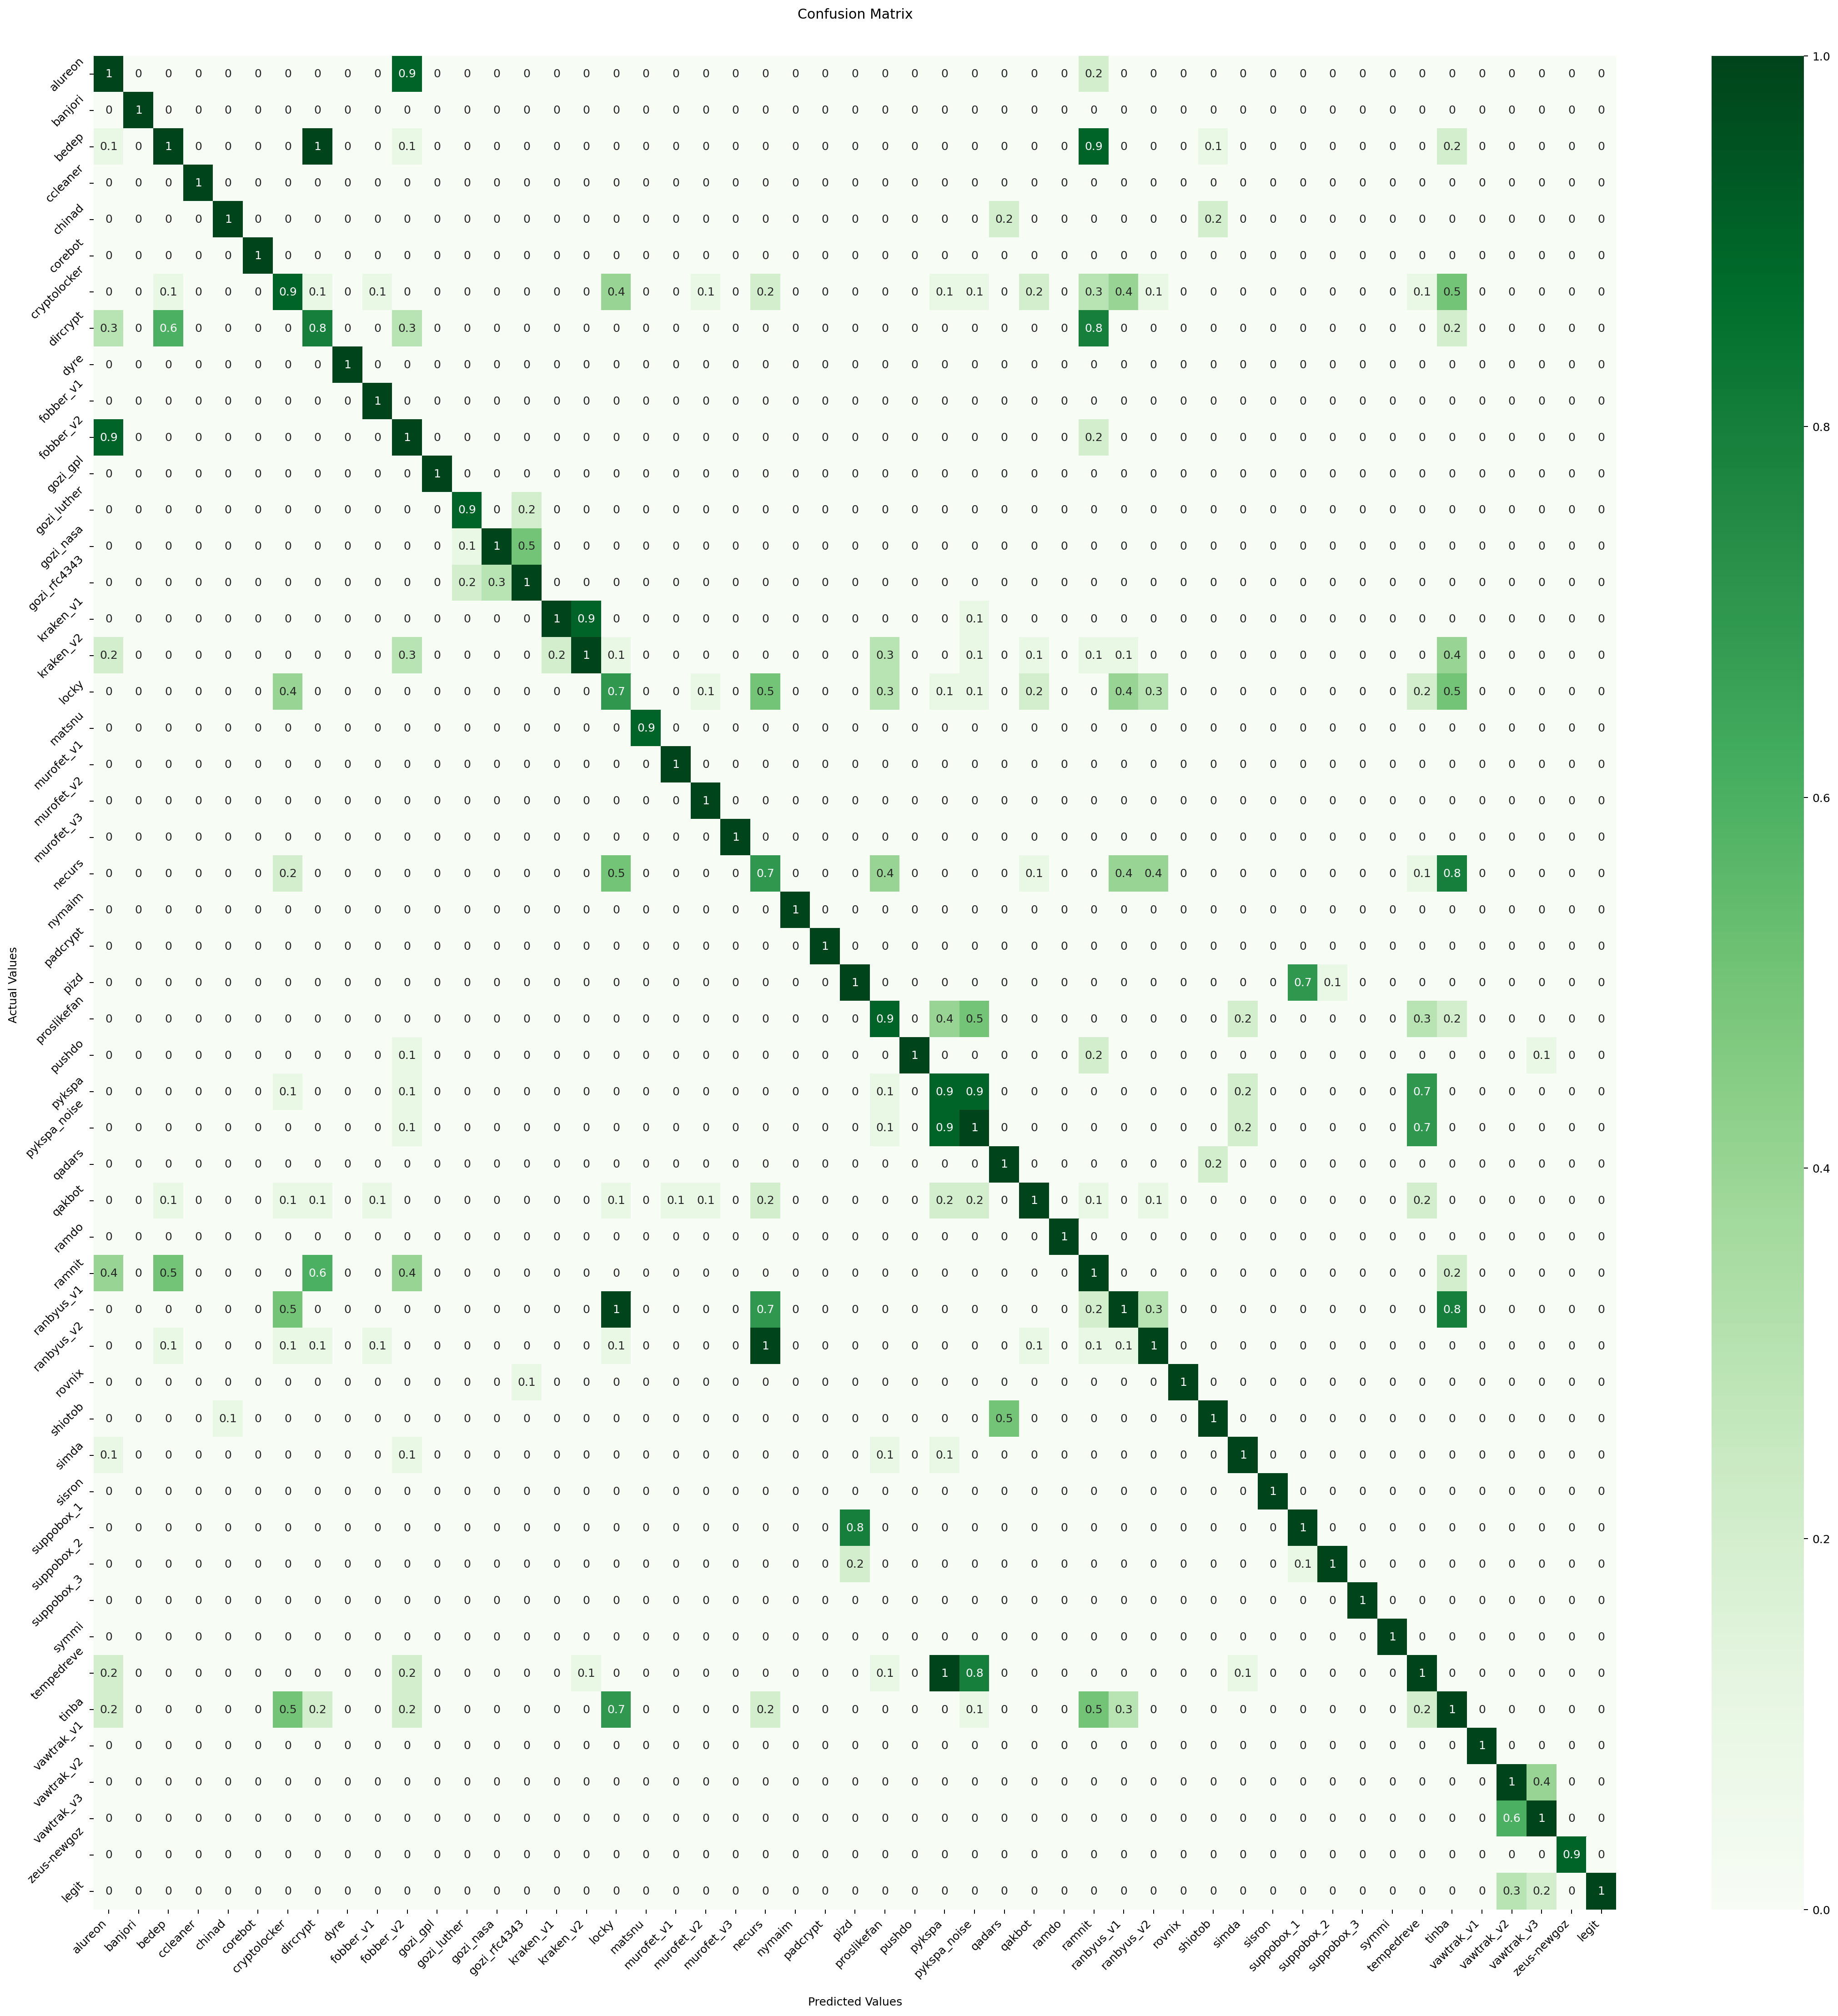

<Figure size 432x288 with 0 Axes>

In [ ]:
get_confusion_matrix('/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Reports/Report/0.017/confusion_matrices/Stacking_conf_matx_FINAL.csv')

## Addestramento con percentuale di train 0.034

In [ ]:
!python3 Main.py --dataset-path ../Dataset/umudga_1k.csv --output-path '/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Reports/Report/0.034' --model Stacking --epochs 20 --with-training --train-perc 0.034 

Using TensorFlow backend.

#############################
Pre-processing started.
#############################


#############################
2-gram pre-processing started.
Number of (different) 2-gram tokens: 1344
Max length of 2-gram tokens: 45
Found 4484 fastText pre-trained embedding vectors.

#############################
3-gram pre-processing started.
Number of (different) 3-gram tokens: 41647
Max length of 3-gram tokens: 44
Found 108494 fastText pre-trained embedding vectors.

#############################
1-gram pre-processing started.
Number of (different) 1-gram tokens: 37
Max length of 1-gram tokens: 46
Found 100 fastText pre-trained embedding vectors.

#############################
Pre-processing terminated.
#############################


#############################
Dictionary of valid classes: {'alureon': 1, 'banjori': 2, 'bedep': 3, 'ccleaner': 4, 'chinad': 5, 'corebot': 6, 'cryptolocker': 7, 'dircrypt': 8, 'dyre': 9, 'fobber_v1': 10, 'fobber_v2': 11, 'gozi_gpl': 12, 

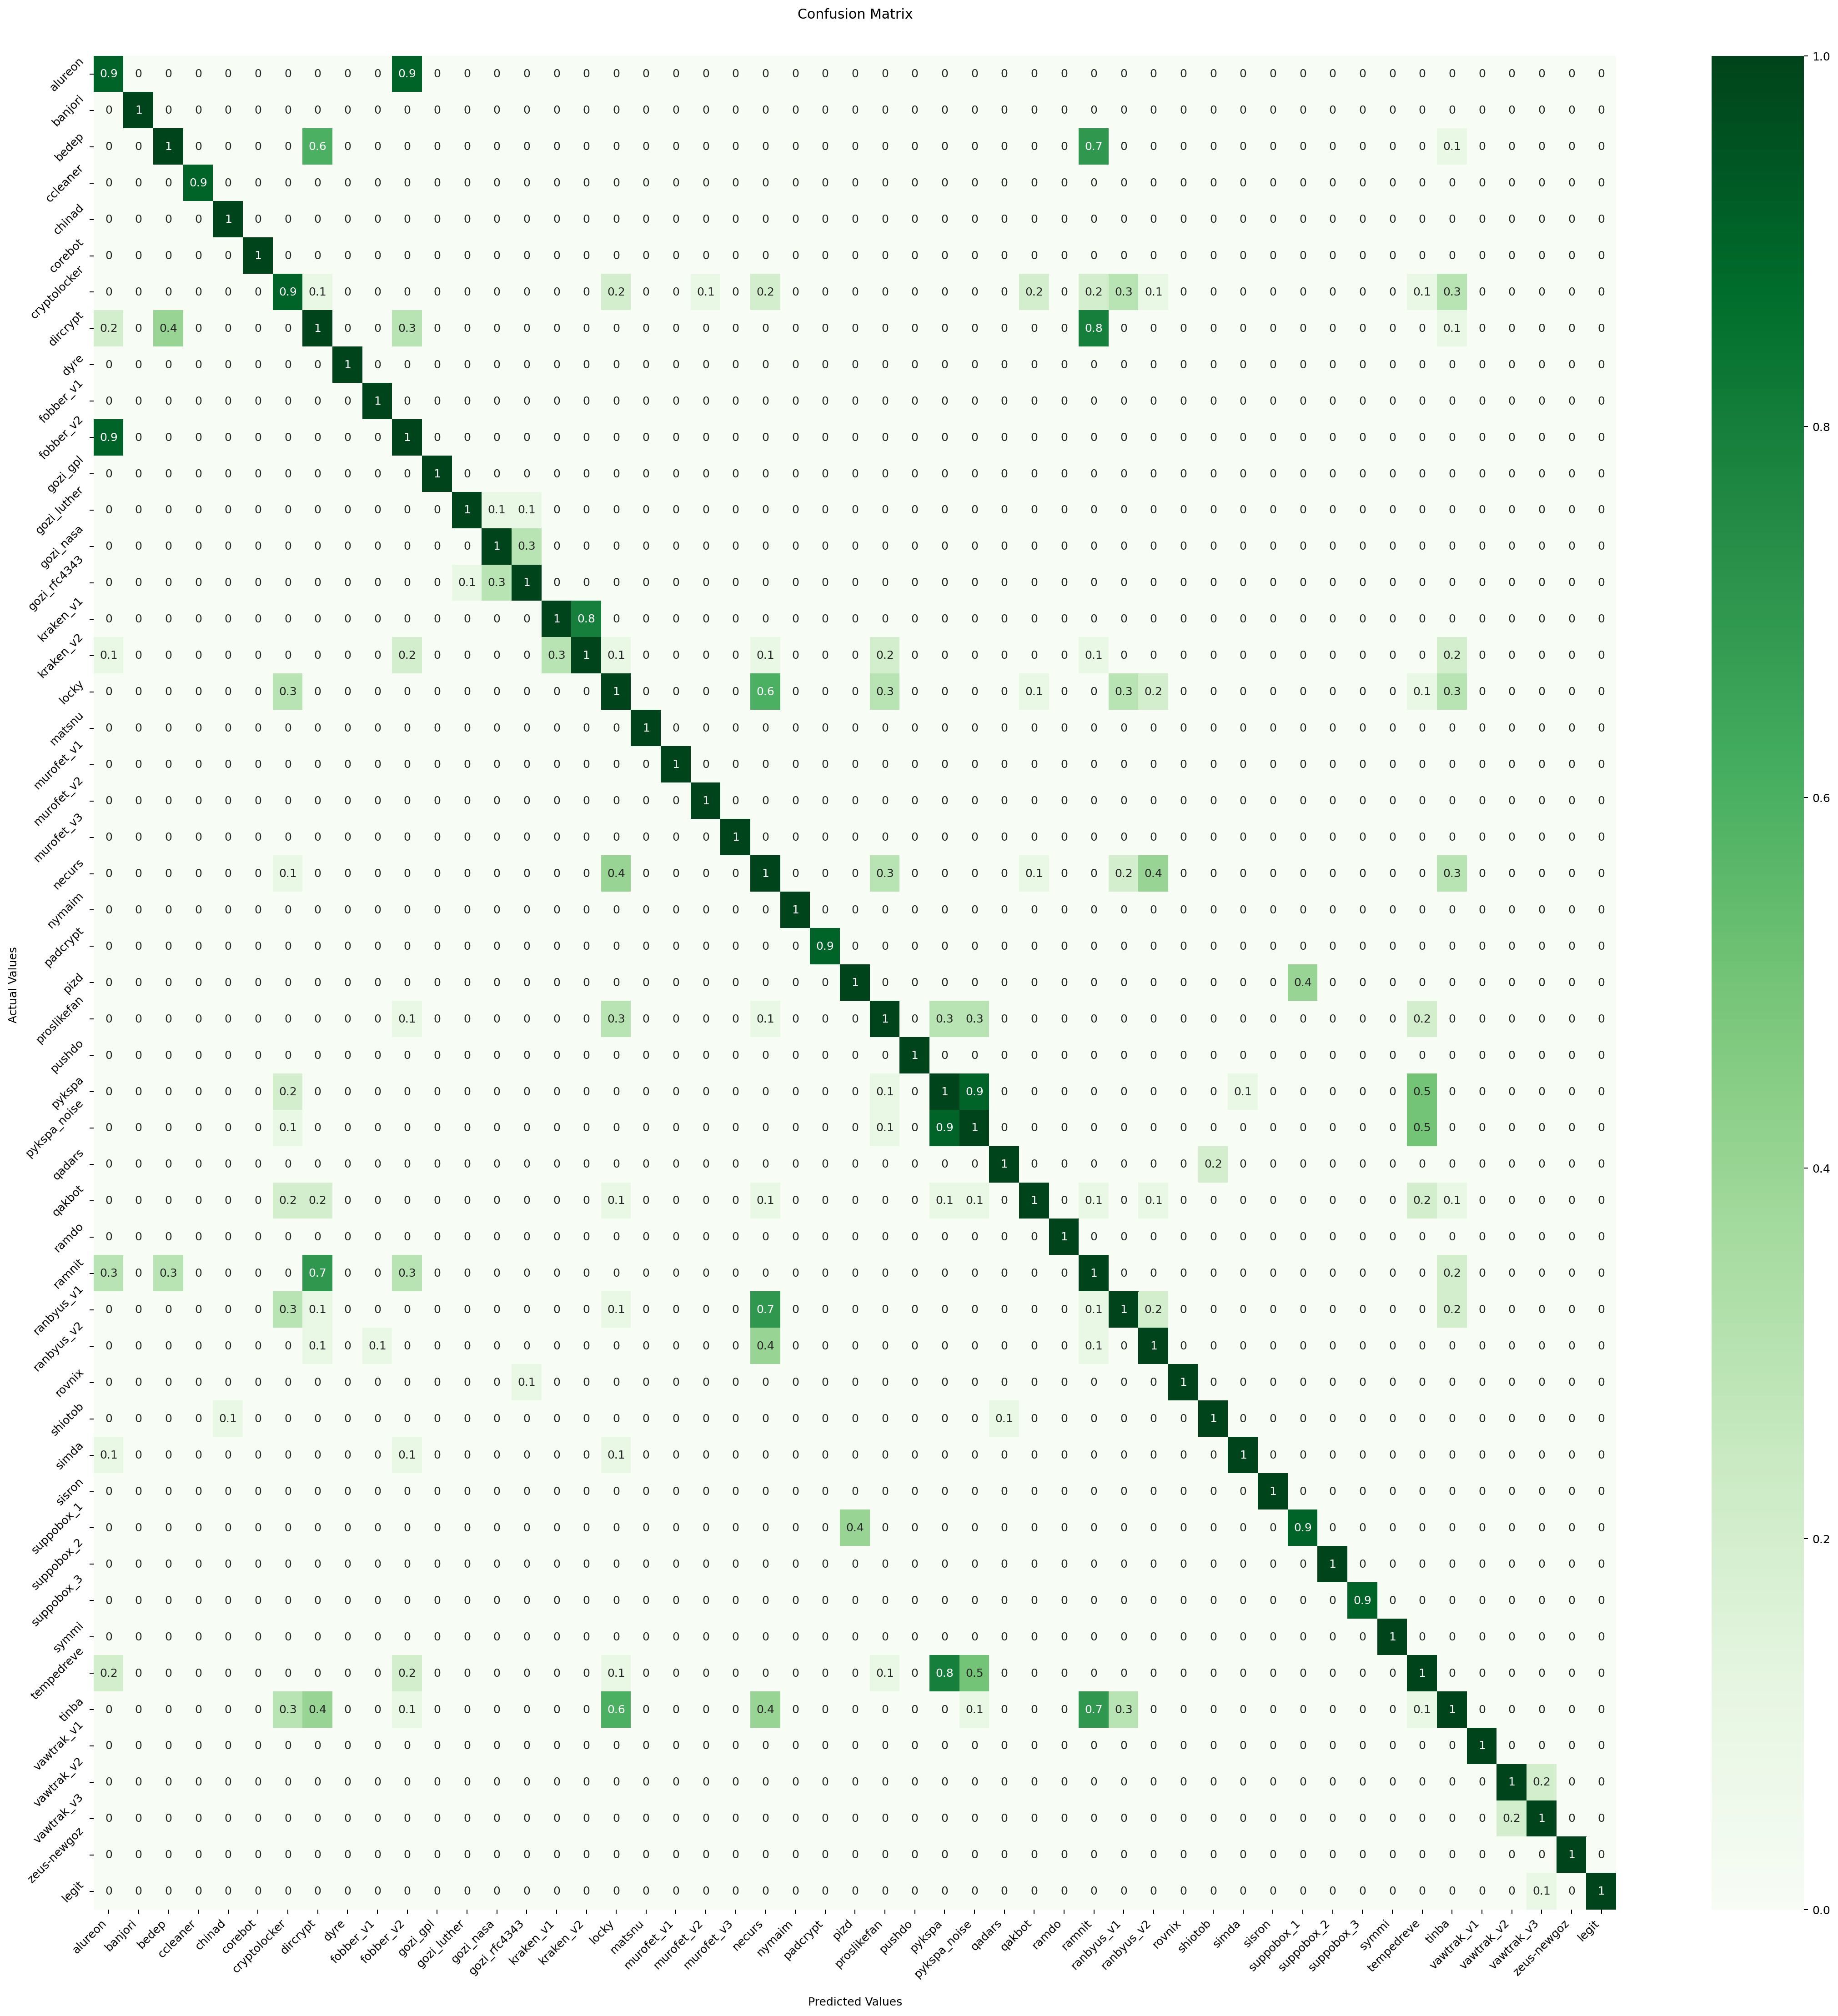

<Figure size 432x288 with 0 Axes>

In [ ]:
get_confusion_matrix('/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Reports/Report/0.034/confusion_matrices/Stacking_conf_matx_FINAL.csv')

## Addestramento con percentuale di train 0.068

In [ ]:
!python3 Main.py --dataset-path ../Dataset/umudga_1k.csv --output-path '/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Reports/Report/0.068' --model Stacking --epochs 20 --with-training --train-perc 0.068

Using TensorFlow backend.

#############################
Pre-processing started.
#############################


#############################
2-gram pre-processing started.
Number of (different) 2-gram tokens: 1344
Max length of 2-gram tokens: 45
Found 4484 fastText pre-trained embedding vectors.

#############################
3-gram pre-processing started.
Number of (different) 3-gram tokens: 41647
Max length of 3-gram tokens: 44
Found 108494 fastText pre-trained embedding vectors.

#############################
1-gram pre-processing started.
Number of (different) 1-gram tokens: 37
Max length of 1-gram tokens: 46
Found 100 fastText pre-trained embedding vectors.

#############################
Pre-processing terminated.
#############################


#############################
Dictionary of valid classes: {'alureon': 1, 'banjori': 2, 'bedep': 3, 'ccleaner': 4, 'chinad': 5, 'corebot': 6, 'cryptolocker': 7, 'dircrypt': 8, 'dyre': 9, 'fobber_v1': 10, 'fobber_v2': 11, 'gozi_gpl': 12, 

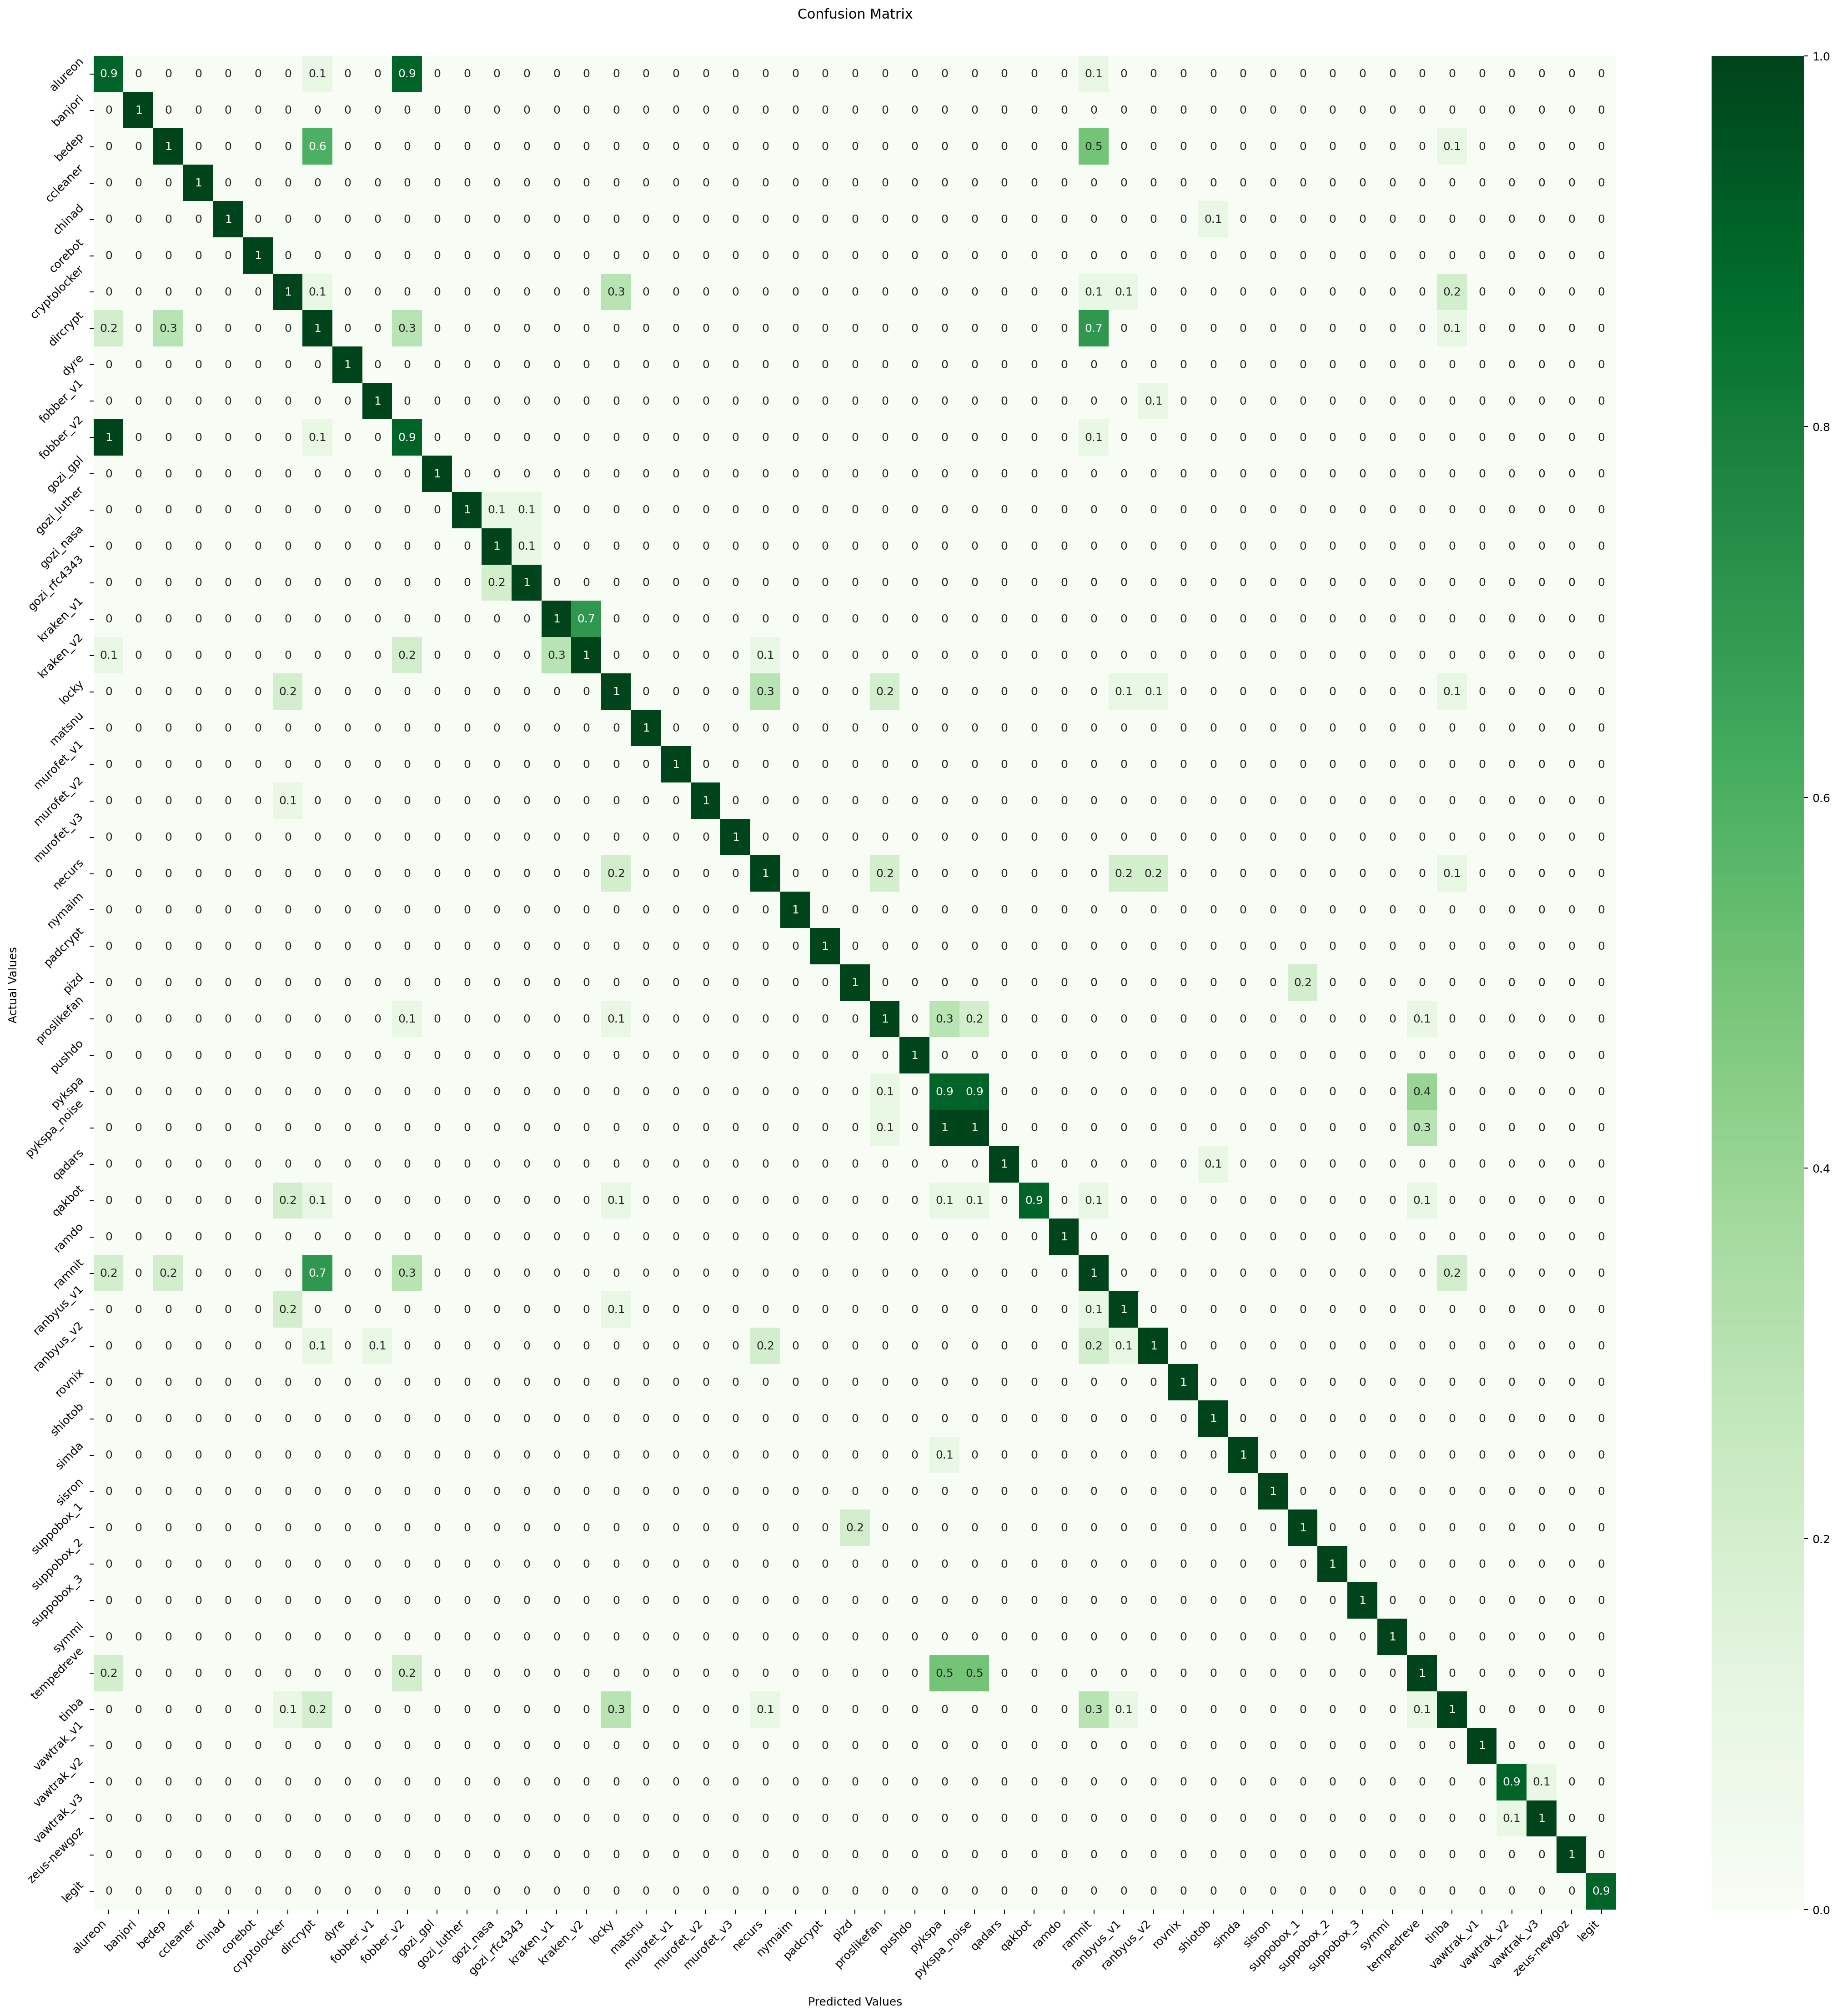

<Figure size 432x288 with 0 Axes>

In [ ]:
get_confusion_matrix('/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Reports/Report/0.068/confusion_matrices/Stacking_conf_matx_FINAL.csv')

## Addestramento con percentuale di train 0.135

In [ ]:
!python3 Main.py --dataset-path ../Dataset/umudga_1k.csv --output-path '/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Reports/Report/0.135' --model Stacking --epochs 20 --with-training --train-perc 0.135 

Using TensorFlow backend.

#############################
Pre-processing started.
#############################


#############################
2-gram pre-processing started.
Number of (different) 2-gram tokens: 1344
Max length of 2-gram tokens: 45
Found 4484 fastText pre-trained embedding vectors.

#############################
3-gram pre-processing started.
Number of (different) 3-gram tokens: 41647
Max length of 3-gram tokens: 44
Found 108494 fastText pre-trained embedding vectors.

#############################
1-gram pre-processing started.
Number of (different) 1-gram tokens: 37
Max length of 1-gram tokens: 46
Found 100 fastText pre-trained embedding vectors.

#############################
Pre-processing terminated.
#############################


#############################
Dictionary of valid classes: {'alureon': 1, 'banjori': 2, 'bedep': 3, 'ccleaner': 4, 'chinad': 5, 'corebot': 6, 'cryptolocker': 7, 'dircrypt': 8, 'dyre': 9, 'fobber_v1': 10, 'fobber_v2': 11, 'gozi_gpl': 12, 

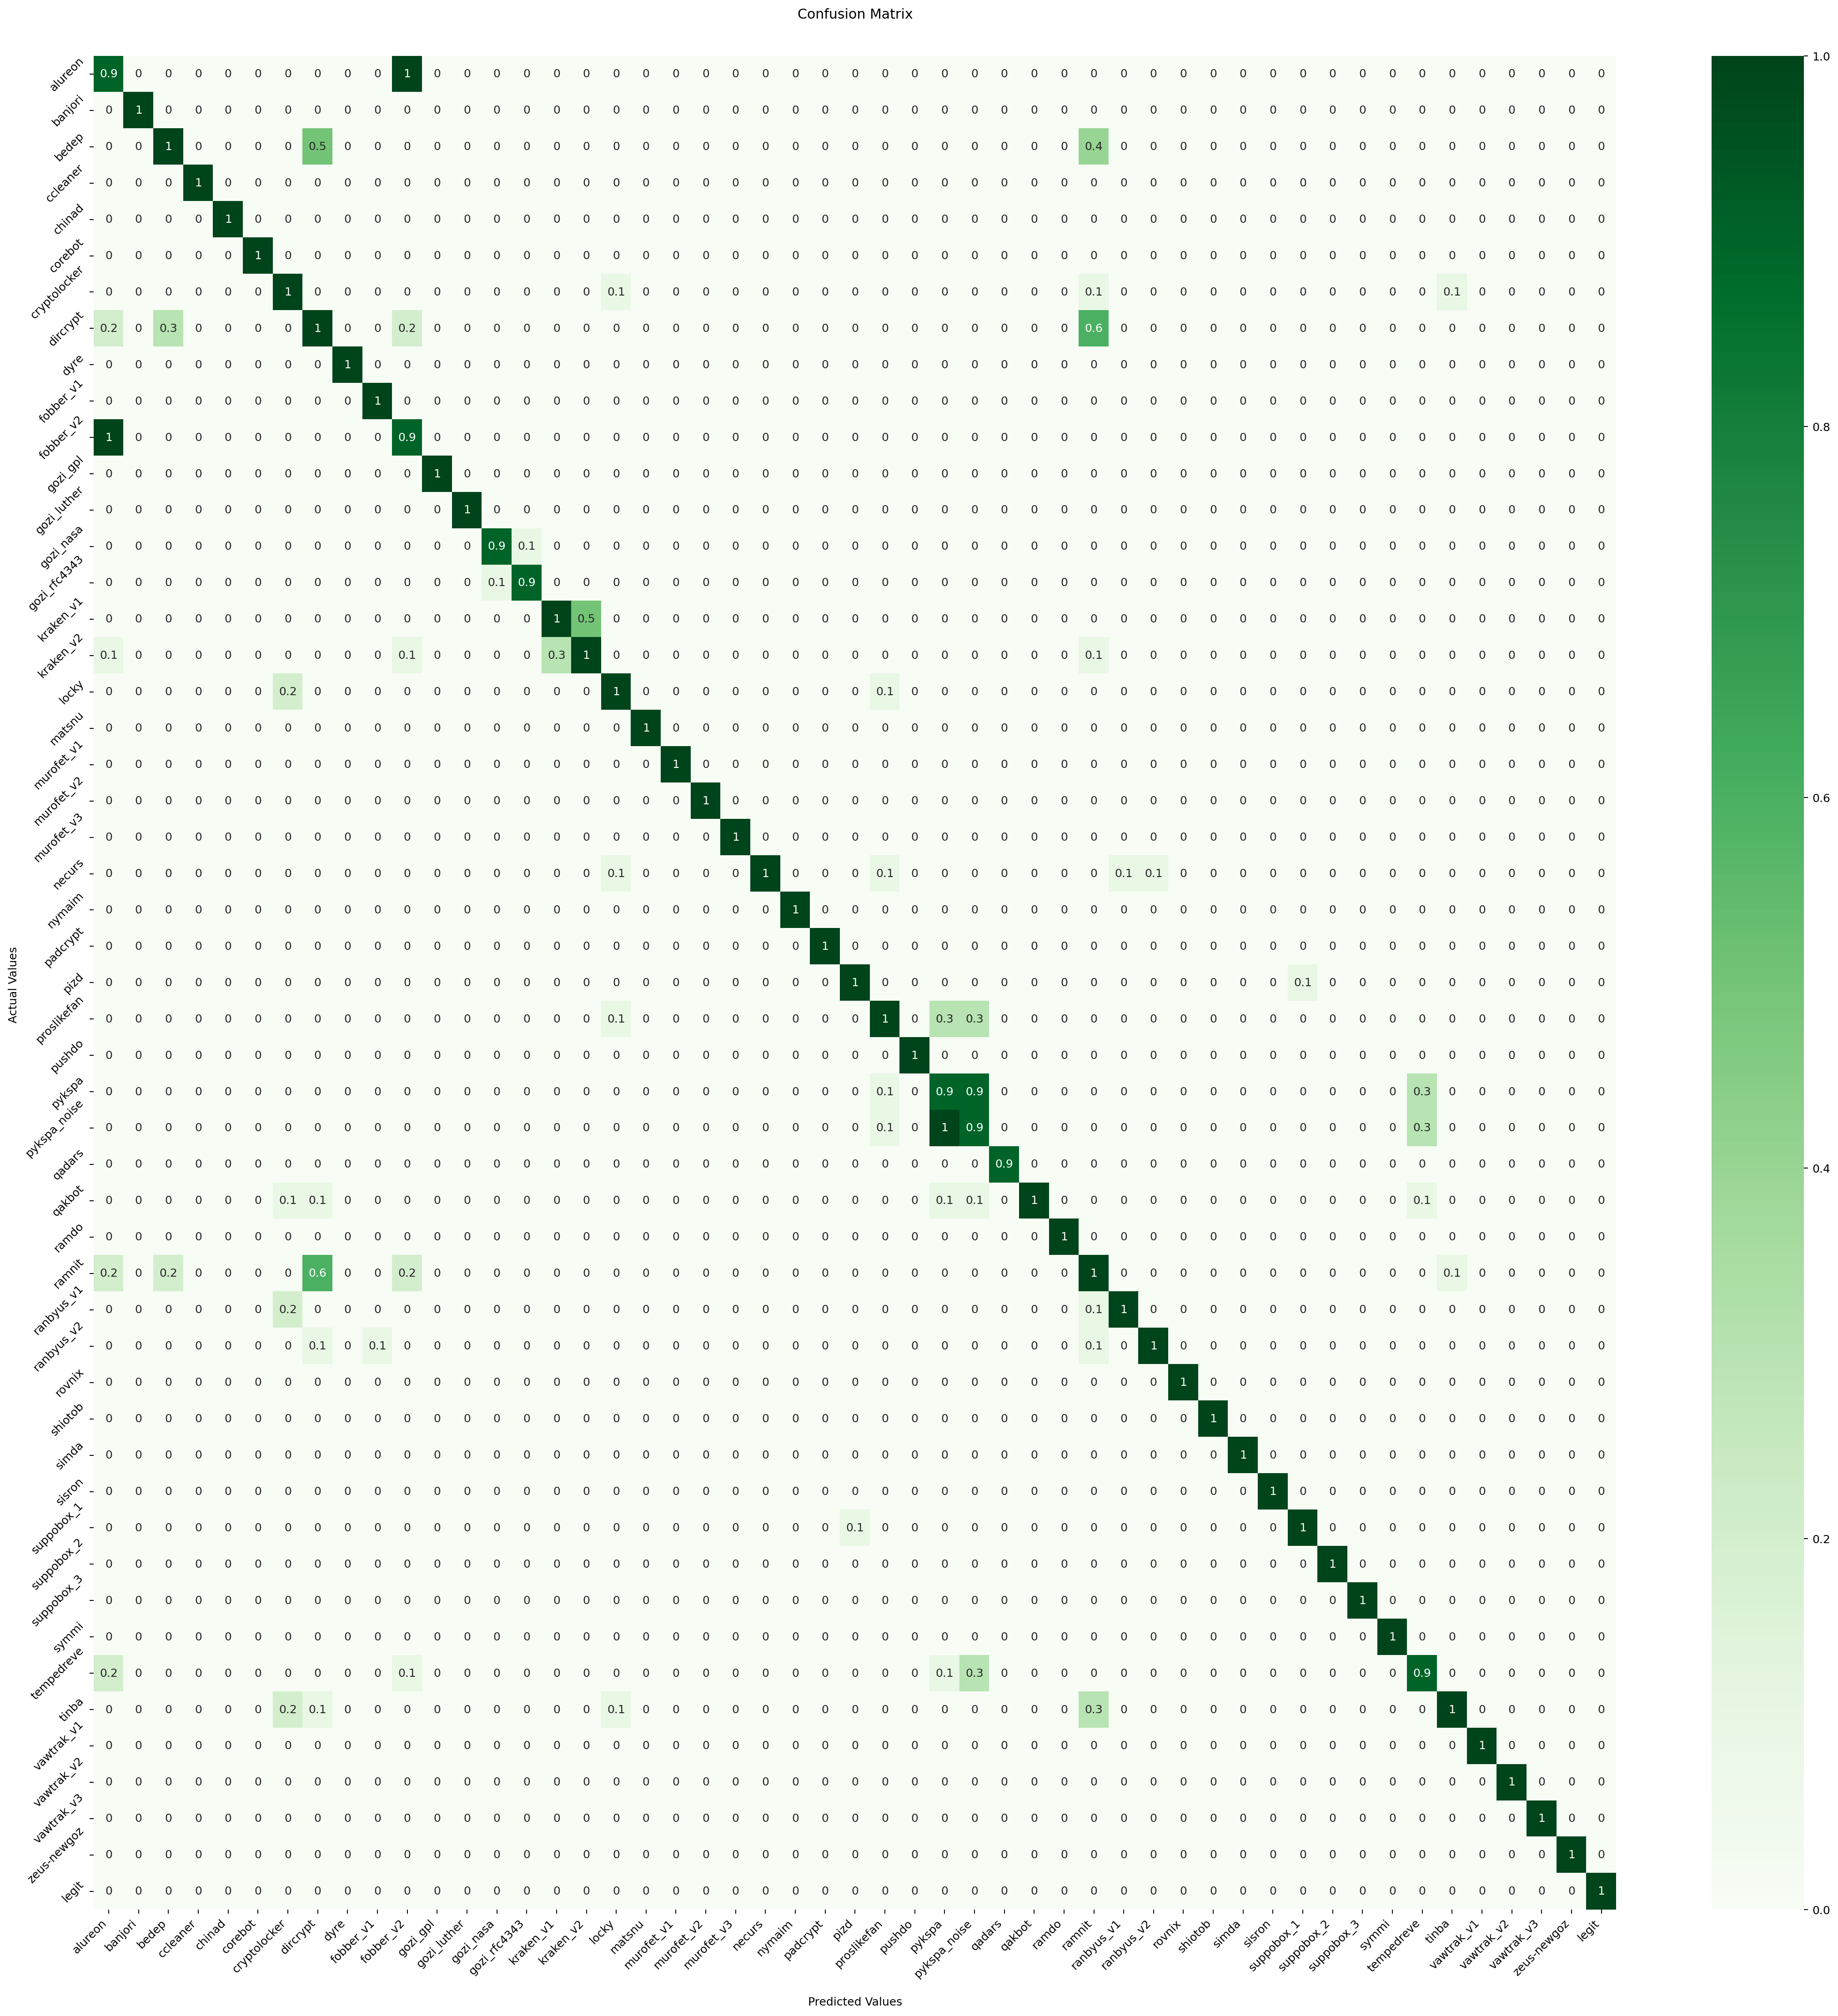

<Figure size 432x288 with 0 Axes>

In [ ]:
get_confusion_matrix('/content/drive/MyDrive/Progetto_Advanced_Cybersecurity/Reports/Report/0.135/confusion_matrices/Stacking_conf_matx_FINAL.csv')